In [1]:
!date

Wed Mar 27 09:10:45 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/pub-CVAE-sim-neuroanatomy/Code'

In [3]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy.spatial.distance import pdist,squareform
from rsa_funcs import fit_rsa,make_RDM,get_triu
from tqdm import tqdm

In [4]:
def get_descriptive(vec,decimals=2):
    vec = np.array(vec)
    if decimals==2:
        print(f'M = {np.nanmean(vec):.2f}, SD = {np.nanstd(vec):.2f}, range {np.nanmin(vec):.2f}-{np.nanmax(vec):.2f}')
    elif decimals==3:
        print(f'M = {np.nanmean(vec):.3f}, SD = {np.nanstd(vec):.3f}, range {np.nanmin(vec):.3f}-{np.nanmax(vec):.3f}')

In [5]:
def pretty_t_1sample(vec,popmean):
    from scipy.stats import ttest_1samp
    t,p = ttest_1samp(vec,popmean,alternative='two-sided')
    if p < .001:
        print(f't({len(vec)-1}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec)-1}) = {t:.2f}, p = {p:.3f}')
        
def pretty_t_ind(vec1,vec2):
    from scipy.stats import ttest_ind
    t,p = ttest_ind(vec1,vec2)
    if p < .001:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

In [6]:
from numpy import arctanh as fisher_z # https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python

In [7]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau

def fit_rsa(rdm_data,rdm_model,metric='kendalltau'):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)

    if metric=='kendalltau':
        #print('metric==kendalltau') 
        return kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif metric=='pearsonr':
        #print('metric==pearsonr') 
        return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    else:
        print('not implemented, wtf')
        return np.nan
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec

In [8]:
data_csv_fn = '../Data/synth-data-01.csv'
#data_csv_fn = '../Data/synth-data-02.csv'
#data_csv_fn = '../Data/synth-data-01-N500.csv'

df = pd.read_csv(data_csv_fn)
n = df.shape[0]
patient_idx = np.nonzero(df['dx'].values==1)[0]
control_idx = np.nonzero(df['dx'].values==0)[0]

rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
triu = np.triu_indices(rdm_tx_s.shape[0],1)
vec_tx_s = rdm_tx_s[triu]
vec_tx_z = rdm_tx_z[triu]

In [9]:
analyses = ['VAE_1type_kncnWVtQih','VAE_1type_UgKpOQRkbT','VAE_1type_kiVqSUuzPw','VAE_1type_ZeaIiXVaJT','VAE_1type_OCsgjPTPfX']

vae_varexps = []
vae_varexps_m = []
latents = []
for analysis in analyses:
    #training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
    #training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
    training_logs_fns = [f for f in os.listdir(f'../Results-latents/{analysis}/') if f.startswith('training_log_')]
    training_logs = [np.load(os.path.join(f'../Results-latents/{analysis}',training_log)) for training_log in training_logs_fns]
    varexp = [training_log['varExps'][-1] for training_log in training_logs]
    varexp = np.array(varexp)
    
    vae_varexps.append( varexp )
    vae_varexps_m.append( varexp.mean() )
    latents.append( [training_log['l_patients'] for training_log in training_logs] )

vae_rsa_z_indiv = []
for i in range(len(latents)):
    vae_rsa_z_indiv.append( [fit_rsa(make_RDM(latents[i][j]),rdm_tx_z) for j in range(len(latents[i]))] )

vae_rsa_s_indiv = []
for i in range(len(latents)):
    vae_rsa_s_indiv.append( [fit_rsa(make_RDM(latents[i][j]),rdm_tx_s) for j in range(len(latents[i]))] )

res_vae = {}
res_vae['vae_varexp_indiv'] = np.array(vae_varexps)
res_vae['vae_varexp_ens'] = np.array(vae_varexps_m)
res_vae['latents'] = np.array(latents)
res_vae['rsa_z_indiv'] = np.array(vae_rsa_z_indiv)
res_vae['rsa_s_indiv'] = np.array(vae_rsa_s_indiv)
res_vae['rsa_s_ens'] = res_vae['rsa_s_indiv'].mean(axis=1)
res_vae['rsa_z_ens'] = res_vae['rsa_z_indiv'].mean(axis=1)

In [10]:
# Individual models
print('VAE: individual models variance explained:')
get_descriptive(res_vae['vae_varexp_indiv'].flatten().flatten())

VAE: individual models variance explained:
M = 0.88, SD = 0.06, range 0.63-0.95


In [11]:
# Ensemble model
print('VAE: ensemble models variance explained:')
get_descriptive(res_vae['vae_varexp_ens'].flatten())

VAE: ensemble models variance explained:
M = 0.88, SD = 0.01, range 0.85-0.89


In [12]:
print('VAE individual: correlation with shared effects:')
get_descriptive(res_vae['rsa_z_indiv'].flatten())

VAE individual: correlation with shared effects:
M = 0.46, SD = 0.03, range 0.41-0.52


In [13]:
print('VAE individual: correlation with disorder-related effects:')
get_descriptive(res_vae['rsa_s_indiv'].flatten())

VAE individual: correlation with disorder-related effects:
M = 0.01, SD = 0.01, range 0.00-0.03


In [14]:
print('VAE ensemble: correlation with shared effects:')
get_descriptive(res_vae['rsa_z_ens'])

VAE ensemble: correlation with shared effects:
M = 0.46, SD = 0.00, range 0.46-0.47


In [15]:
print('VAE ensemble: correlation with disorder-related effects:')
get_descriptive(res_vae['rsa_s_ens'])

VAE ensemble: correlation with disorder-related effects:
M = 0.01, SD = 0.00, range 0.01-0.01


In [16]:
pretty_t_1sample(fisher_z(res_vae['rsa_s_ens']),popmean=0)

t(4) = 14.98, p < .001


In [17]:
def get_CVAE_res(analyses,data_csv_fn='../Data/synth-data-01.csv'):


    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    s_latents = []
    z_latents = []
    cvae_varexps = []
    cvae_varexps_m = []
    
    loss = []
    loss_mse = []
    loss_kl = []
    loss_tc = []
    loss_dc = []
    mus = []
    sigmas = []
    c_sim = []
    corr_z_s = []
    for analysis in analyses:
        # training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
        # training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
        training_logs_fns = [f for f in os.listdir(f'../Results-latents/{analysis}') if f.startswith('training_log_')]
        training_logs = [np.load(os.path.join(f'../Results-latents/{analysis}',training_log)) for training_log in training_logs_fns]
        varexp = [training_log['varExps'][-1] for training_log in training_logs]
        varexp = np.array(varexp)
        
        cvae_varexps.append( varexp )
        cvae_varexps_m.append( varexp.mean() )
        s_latents.append( [training_log['s_patients'] for training_log in training_logs] )
        z_latents.append( [training_log['z_patients'] for training_log in training_logs] )
    
        loss.append( [training_log['loss'][-1] for training_log in training_logs] )
        loss_mse.append( [training_log['loss_mse'][-1] for training_log in training_logs] )
        loss_kl.append( [training_log['loss_kl'][-1] for training_log in training_logs] )
        loss_tc.append( [training_log['loss_tc'][-1] for training_log in training_logs] )
        loss_dc.append( [training_log['loss_dc'][-1] for training_log in training_logs] )
        
    
        mus.append( [training_log['mus'][-1] for training_log in training_logs] )
        sigmas.append( [training_log['sigmas'][-1] for training_log in training_logs] )
        c_sim.append( [training_log['c_sim'][-1] for training_log in training_logs] )
        corr_z_s.append( [training_log['corr_z_s'][-1] for training_log in training_logs] )

    cvae_rsa_z_indiv = []
    cvae_rsa_zs_indiv = []
    for i in range(len(z_latents)):
            cvae_rsa_z_indiv.append( [fit_rsa(make_RDM(z_latents[i][j][-1,:,:]),rdm_tx_z) for j in range(len(z_latents[i]))] )
            cvae_rsa_zs_indiv.append( [fit_rsa(make_RDM(z_latents[i][j][-1,:,:]),rdm_tx_s) for j in range(len(z_latents[i]))] )
    
    cvae_rsa_s_indiv = []
    cvae_rsa_sz_indiv = []
    for i in range(len(s_latents)):
            cvae_rsa_s_indiv.append( [fit_rsa(make_RDM(s_latents[i][j][-1,:,:]),rdm_tx_s) for j in range(len(s_latents[i]))] )
            cvae_rsa_sz_indiv.append( [fit_rsa(make_RDM(s_latents[i][j][-1,:,:]),rdm_tx_z) for j in range(len(s_latents[i]))] )
        
    res_cvae = {}
    res_cvae['cvae_varexps'] = np.array(cvae_varexps)
    res_cvae['cvae_varexps_m'] = np.array(cvae_varexps_m)
    res_cvae['s_latents'] = np.array(s_latents)
    res_cvae['z_latents'] = np.array(z_latents)
    res_cvae['loss'] = np.array(loss)
    res_cvae['loss_mse'] = np.array(loss_mse)
    res_cvae['loss_kl'] = np.array(loss_kl)
    res_cvae['loss_tc'] = np.array(loss_tc)
    res_cvae['loss_dc'] = np.array(loss_dc)
    res_cvae['mus'] = np.array(mus)
    res_cvae['sigmas'] = np.array(sigmas)
    res_cvae['c_sim'] = np.array(c_sim)
    res_cvae['corr_z_s'] = np.array(corr_z_s)
    res_cvae['rsa_z_indiv'] = np.array(cvae_rsa_z_indiv)
    res_cvae['rsa_s_indiv'] = np.array(cvae_rsa_s_indiv)

    res_cvae['rsa_zs_indiv'] = np.array(cvae_rsa_zs_indiv)
    res_cvae['rsa_sz_indiv'] = np.array(cvae_rsa_sz_indiv)
    
    res_cvae['rsa_z_ens'] = np.nanmean(res_cvae['rsa_z_indiv'],axis=1)
    res_cvae['rsa_s_ens'] = np.nanmean(res_cvae['rsa_s_indiv'],axis=1)
    res_cvae['rsa_zs_ens'] = np.nanmean(res_cvae['rsa_zs_indiv'],axis=1)
    res_cvae['rsa_sz_ens'] = np.nanmean(res_cvae['rsa_sz_indiv'],axis=1)
    #res_cvae[''] = np.array()

    [print(f'{key} | {res_cvae[key].shape}') for key in list(res_cvae.keys())];

    return res_cvae

In [18]:
analyses = ['good-WGEYQtcZZJ','good-mbKzlWMysG','good-CfFxxcHpOS','good-QQXNZRBSTz','good-CIMgmCzfEA']
res_cvae = get_CVAE_res(analyses)

cvae_varexps | (5, 20)
cvae_varexps_m | (5,)
s_latents | (5, 20, 100, 500, 2)
z_latents | (5, 20, 100, 500, 2)
loss | (5, 20)
loss_mse | (5, 20)
loss_kl | (5, 20)
loss_tc | (5, 20)
loss_dc | (5, 20)
mus | (5, 20)
sigmas | (5, 20)
c_sim | (5, 20)
corr_z_s | (5, 20)
rsa_z_indiv | (5, 20)
rsa_s_indiv | (5, 20)
rsa_zs_indiv | (5, 20)
rsa_sz_indiv | (5, 20)
rsa_z_ens | (5,)
rsa_s_ens | (5,)
rsa_zs_ens | (5,)
rsa_sz_ens | (5,)


In [19]:
temp=res_cvae['loss'].mean(axis=1);print(f'ens loss: {temp.min():.0f}-{temp.max():.0f}')
temp=res_cvae['loss_mse'].mean(axis=1);print(f'ens loss mse: {temp.min():.2f}-{temp.max():.2f}')
temp=res_cvae['loss_kl'].mean(axis=1);print(f'ens loss KL: {temp.min():.2f}-{temp.max():.2f}')

ens loss: 328-353
ens loss mse: 5.71-6.39
ens loss KL: 27.85-28.89


In [20]:
print('CVAE individual: Variance explained:')
get_descriptive(res_cvae['cvae_varexps'].flatten())

CVAE individual: Variance explained:
M = 0.89, SD = 0.02, range 0.80-0.92


In [21]:
print('CVAE ensemble: Variance explained:')
get_descriptive(res_cvae['cvae_varexps_m'])

CVAE ensemble: Variance explained:
M = 0.89, SD = 0.01, range 0.88-0.90


In [22]:
print('CVAE individual: correlation with shared effects:')
get_descriptive(res_cvae['rsa_z_indiv'].flatten())

CVAE individual: correlation with shared effects:
M = 0.48, SD = 0.03, range 0.41-0.53


In [23]:
print('CVAE individual: correlation with disorder-related effects:')
get_descriptive(res_cvae['rsa_s_indiv'].flatten())

CVAE individual: correlation with disorder-related effects:
M = 0.21, SD = 0.07, range 0.05-0.38


In [24]:
print('CVAE ensemble: correlation with shared effects:')
get_descriptive(res_cvae['rsa_z_ens'])

CVAE ensemble: correlation with shared effects:
M = 0.48, SD = 0.01, range 0.47-0.49


In [25]:
print('CVAE ensemble: correlation with disorder-related effects:')
get_descriptive(res_cvae['rsa_s_ens'])

CVAE ensemble: correlation with disorder-related effects:
M = 0.21, SD = 0.01, range 0.19-0.23


In [26]:
print('CVAE ensemble cross-corr: correlation of shared features with disorder-related effects:')
get_descriptive(res_cvae['rsa_zs_ens'],decimals=3)

CVAE ensemble cross-corr: correlation of shared features with disorder-related effects:
M = 0.010, SD = 0.001, range 0.009-0.011


In [27]:
print('CVAE ensemble cross-corr: correlation of disorder-related features with shared effects:')
get_descriptive(res_cvae['rsa_sz_ens'])

CVAE ensemble cross-corr: correlation of disorder-related features with shared effects:
M = 0.15, SD = 0.01, range 0.13-0.15


In [28]:
print('Disorder-specific features: Correlelation with Disorder-specific ground-truth, Corr. with Shared ground-truth, difference')
'SS={:.2f},SZ={:.2f},ΔM={:.2f}'.format(res_cvae['rsa_s_ens'].mean(),res_cvae['rsa_sz_ens'].mean(),res_cvae['rsa_s_ens'].mean()-res_cvae['rsa_sz_ens'].mean())

Disorder-specific features: Correlelation with Disorder-specific ground-truth, Corr. with Shared ground-truth, difference


'SS=0.21,SZ=0.15,ΔM=0.07'

In [29]:
print('disorder-specific features correlate more with disorder-specific ground-truth than with shared ground-truth')
pretty_t_ind(fisher_z(res_cvae['rsa_s_ens']),fisher_z(res_cvae['rsa_sz_ens']))

disorder-specific features correlate more with disorder-specific ground-truth than with shared ground-truth
t(8) = 9.44, p < .001


In [30]:
print('Shared features: Correlation with Shared ground-truth, Corr. with Disorder-specific ground-truth, difference')
'ZZ={:.2f},ZS={:.2f},ΔM={:.2f}'.format(res_cvae['rsa_z_ens'].mean(),res_cvae['rsa_zs_ens'].mean(),res_cvae['rsa_z_ens'].mean()-res_cvae['rsa_zs_ens'].mean())

Shared features: Correlation with Shared ground-truth, Corr. with Disorder-specific ground-truth, difference


'ZZ=0.48,ZS=0.01,ΔM=0.47'

In [31]:
print('Shared features correlate more with shared ground-truth than with disorder-specific ground-truth')
pretty_t_ind(fisher_z(res_cvae['rsa_z_ens']),fisher_z(res_cvae['rsa_zs_ens']))

Shared features correlate more with shared ground-truth than with disorder-specific ground-truth
t(8) = 121.57, p < .001


## CVAE > VAE

In [32]:
print('Variance explained CVAE>VAE')
pretty_t_1sample(fisher_z(res_vae['vae_varexp_ens']-res_cvae['cvae_varexps_m']),0)

Variance explained CVAE>VAE
t(4) = -1.96, p = 0.121


In [33]:
print('Shared featured. VAE,CVAE,difference')
'VAE Z = {:.2f}, CVAE Z = {:.2f}, ΔM ={:.2f}'.format(res_vae['rsa_z_ens'].mean(),res_cvae['rsa_z_ens'].mean(),res_cvae['rsa_z_ens'].mean()-res_vae['rsa_z_ens'].mean())

Shared featured. VAE,CVAE,difference


'VAE Z = 0.46, CVAE Z = 0.48, ΔM =0.01'

In [34]:
print('Correlation with shared. CVAE > VAE')
pretty_t_ind(fisher_z(res_cvae['rsa_z_ens']),fisher_z(res_vae['rsa_z_ens']))

Correlation with shared. CVAE > VAE
t(8) = 3.66, p = 0.006


In [35]:
print('Specific featured. VAE,CVAE,difference')
'VAE Z = {:.2f}, CVAE Z = {:.2f}, ΔM ={:.2f}'.format(res_vae['rsa_s_ens'].mean(),res_cvae['rsa_s_ens'].mean(),res_cvae['rsa_s_ens'].mean()-res_vae['rsa_s_ens'].mean())

Specific featured. VAE,CVAE,difference


'VAE Z = 0.01, CVAE Z = 0.21, ΔM =0.20'

In [36]:
print('Correlation with shared. CVAE > VAE')
pretty_t_ind(fisher_z(res_cvae['rsa_s_ens']),fisher_z(res_vae['rsa_s_ens']))

Correlation with shared. CVAE > VAE
t(8) = 30.59, p < .001


M = 0.99, SD = 0.01, range 0.98-1.00
M = 0.99, SD = 0.00, range 0.98-1.00


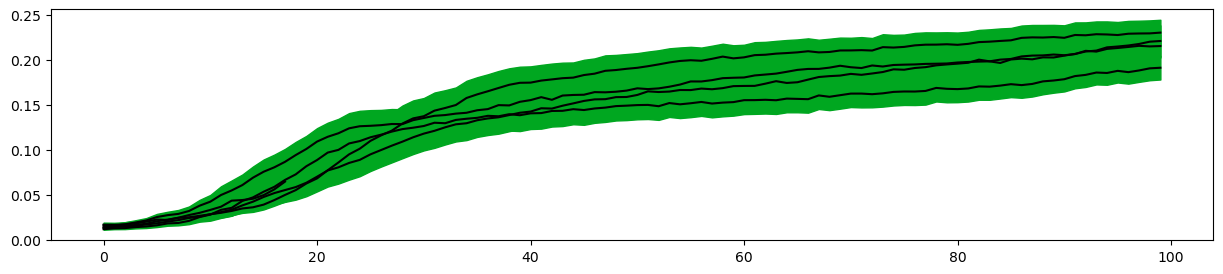

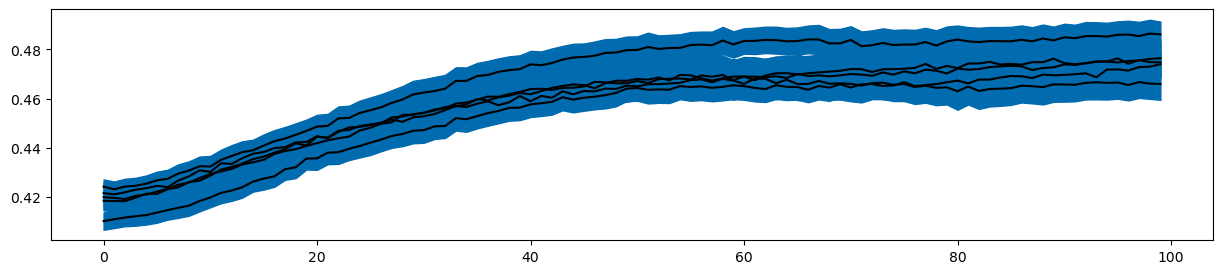

In [37]:
load_or_calc = 'load'

if load_or_calc=='calc':
    rsa_vec_s = np.zeros((5,20,100))
    rsa_vec_z = np.zeros((5,20,100))
    for ensemble in range(5):
        for model in tqdm(range(20)):
            for epoch in range(100):
                rsa_vec_s[ensemble,model,epoch] = fit_rsa(make_RDM(s_latents[ensemble][model][epoch,:,:]),rdm_tx_s)
                rsa_vec_z[ensemble,model,epoch] = fit_rsa(make_RDM(z_latents[ensemble][model][epoch,:,:]),rdm_tx_z)
                
    np.save(file='../Results/rsa_vec_s.npy', arr=rsa_vec_s)
    np.save(file='../Results/rsa_vec_z.npy', arr=rsa_vec_z)
else:

    rsa_vec_s = np.load('../Results/rsa_vec_s.npy')
    rsa_vec_z = np.load('../Results/rsa_vec_z.npy')


plt.figure(figsize=(15,3))
for i in range(5):
    m = rsa_vec_s.mean(axis=1)[i,:]
    se = rsa_vec_s.std(axis=1)[i,:] / np.sqrt(20)
    xs = np.arange(100)
    plt.plot(m,'k-')
    plt.fill_between(xs,m+se,m-se,color=np.array([0,167,32])/255)


plt.figure(figsize=(15,3))
for i in range(5):
    m = rsa_vec_z.mean(axis=1)[i,:]
    se = rsa_vec_z.std(axis=1)[i,:] / np.sqrt(20)
    xs = np.arange(100)
    plt.plot(m,'k-')
    plt.fill_between(xs,m+se,m-se,color=np.array([0,107,175])/255)

triu = np.triu_indices(5,1)
get_descriptive(np.corrcoef(np.nanmean(rsa_vec_s,axis=1))[triu])
get_descriptive(np.corrcoef(np.nanmean(rsa_vec_z,axis=1))[triu])

In [38]:
# analyses = ['N500-RIxKgBtgMj','N500-vHXUYIlWPw','N500-yIIUviVmbl','N500-knhKEbsyWA','N500-InbUXvmqdK']

# n_500_s_latents = []
# n_500_z_latents = []
# n_500_cvae_varexps = []
# n_500_cvae_varexps_m = []

# for analysis in analyses:
#     training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
#     training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
#     varexp = [training_log['varExps'][-1] for training_log in training_logs]
#     varexp = np.array(varexp)
    
#     n_500_cvae_varexps.append( varexp )
#     n_500_cvae_varexps_m.append( varexp.mean() )
#     n_500_s_latents.append( [training_log['s_patients'] for training_log in training_logs] )
#     n_500_z_latents.append( [training_log['z_patients'] for training_log in training_logs] )

# n_500_s_latents = np.array(n_500_s_latents)
# n_500_z_latents = np.array(n_500_z_latents)
# n_500_cvae_varexps = np.array(n_500_cvae_varexps)
# n_500_cvae_varexps_m = np.array(n_500_cvae_varexps_m)

# print(n_500_s_latents.shape)
# print(n_500_z_latents.shape)
# print(n_500_cvae_varexps.shape)
# print(n_500_cvae_varexps_m.shape)

In [39]:
res_cvae_8D = get_CVAE_res(['DIM-8dVIawRUDpG','DIM-8IgCIInpdyf','DIM-8dTEcVhzcaN','DIM-8CTVvqgoBiO','DIM-8PONlzRTNFh'],data_csv_fn='../Data/synth-data-01.csv')

cvae_varexps | (5, 20)
cvae_varexps_m | (5,)
s_latents | (5, 20, 100, 500, 8)
z_latents | (5, 20, 100, 500, 8)
loss | (5, 20)
loss_mse | (5, 20)
loss_kl | (5, 20)
loss_tc | (5, 20)
loss_dc | (5, 20)
mus | (5, 20)
sigmas | (5, 20)
c_sim | (5, 20)
corr_z_s | (5, 20)
rsa_z_indiv | (5, 20)
rsa_s_indiv | (5, 20)
rsa_zs_indiv | (5, 20)
rsa_sz_indiv | (5, 20)
rsa_z_ens | (5,)
rsa_s_ens | (5,)
rsa_zs_ens | (5,)
rsa_sz_ens | (5,)


In [40]:
get_descriptive(res_cvae_8D['cvae_varexps_m'])

M = 0.91, SD = 0.01, range 0.89-0.92


In [41]:
get_descriptive(res_cvae_8D['rsa_s_ens'])

M = 0.31, SD = 0.04, range 0.25-0.37


In [42]:
get_descriptive(res_cvae_8D['rsa_z_ens'])

M = 0.47, SD = 0.01, range 0.46-0.48


In [43]:
pretty_t_ind(fisher_z(res_cvae_8D['rsa_z_ens']),fisher_z(res_cvae['rsa_z_ens']))

t(8) = -0.29, p = 0.782


In [44]:
pretty_t_ind(fisher_z(res_cvae_8D['rsa_s_ens']),fisher_z(res_cvae['rsa_s_ens']))

t(8) = 4.37, p = 0.002


In [45]:
print('Variance explained 8D > 2D')
pretty_t_1sample(fisher_z(res_cvae_8D['cvae_varexps_m'])-fisher_z(res_cvae['cvae_varexps_m']),0)

Variance explained 8D > 2D
t(4) = 4.07, p = 0.015


In [46]:
print('RSA with Disorder-specific 8D > 2D')
pretty_t_ind(fisher_z(res_cvae_8D['rsa_s_ens']),fisher_z(res_cvae['rsa_s_ens']))

RSA with Disorder-specific 8D > 2D
t(8) = 4.37, p = 0.002


In [47]:

res_cvae_N500 = get_CVAE_res(['N500-RIxKgBtgMj','N500-vHXUYIlWPw','N500-yIIUviVmbl','N500-knhKEbsyWA','N500-InbUXvmqdK'],data_csv_fn='../Data/synth-data-01-N500.csv')


cvae_varexps | (5, 20)
cvae_varexps_m | (5,)
s_latents | (5, 20, 100, 250, 2)
z_latents | (5, 20, 100, 250, 2)
loss | (5, 20)
loss_mse | (5, 20)
loss_kl | (5, 20)
loss_tc | (5, 20)
loss_dc | (5, 20)
mus | (5, 20)
sigmas | (5, 20)
c_sim | (5, 20)
corr_z_s | (5, 20)
rsa_z_indiv | (5, 20)
rsa_s_indiv | (5, 20)
rsa_zs_indiv | (5, 20)
rsa_sz_indiv | (5, 20)
rsa_z_ens | (5,)
rsa_s_ens | (5,)
rsa_zs_ens | (5,)
rsa_sz_ens | (5,)


In [48]:
print('N500 Variance explained')
get_descriptive(res_cvae_N500['cvae_varexps_m'])
print('\n')

print('N500 Shared RSA')
get_descriptive(res_cvae_N500['rsa_z_ens'])
print('\n')

print('N500 Specific RSA')
get_descriptive(res_cvae_N500['rsa_s_ens'])
print('\n')

print('Variance explained N1000>N500')
pretty_t_1sample(fisher_z(res_cvae['cvae_varexps_m']-res_cvae_N500['cvae_varexps_m']),0)
print('\n')

print('RSA shared N1000>N500')
pretty_t_ind(fisher_z(res_cvae['rsa_z_ens']),fisher_z(res_cvae_N500['rsa_z_ens']))
print('\n')

print('RSA specific N1000>N500')
pretty_t_ind(fisher_z(res_cvae['rsa_s_ens']),fisher_z(res_cvae_N500['rsa_s_ens']))

N500 Variance explained
M = 0.84, SD = 0.01, range 0.83-0.85


N500 Shared RSA
M = 0.47, SD = 0.01, range 0.47-0.48


N500 Specific RSA
M = 0.18, SD = 0.02, range 0.16-0.21


Variance explained N1000>N500
t(4) = 9.34, p < .001


RSA shared N1000>N500
t(8) = 0.69, p = 0.510


RSA specific N1000>N500
t(8) = 3.17, p = 0.013


In [49]:

res_cvae_N200 = get_CVAE_res(['N200-fix-ecgLoaZUBd','N200-fix-AzJewVzNDC','N200-fix-DzsjKrsbze','N200-fix-tVSrAEvqkF','N200-fix-eqsoMaLksq'],data_csv_fn='../Data/synth-data-01-N200.csv')


cvae_varexps | (5, 20)
cvae_varexps_m | (5,)
s_latents | (5, 20, 100, 100, 2)
z_latents | (5, 20, 100, 100, 2)
loss | (5, 20)
loss_mse | (5, 20)
loss_kl | (5, 20)
loss_tc | (5, 20)
loss_dc | (5, 20)
mus | (5, 20)
sigmas | (5, 20)
c_sim | (5, 20)
corr_z_s | (5, 20)
rsa_z_indiv | (5, 20)
rsa_s_indiv | (5, 20)
rsa_zs_indiv | (5, 20)
rsa_sz_indiv | (5, 20)
rsa_z_ens | (5,)
rsa_s_ens | (5,)
rsa_zs_ens | (5,)
rsa_sz_ens | (5,)


In [50]:
print(res_cvae_N200['rsa_s_ens'])
print(res_cvae_N500['rsa_s_ens'])
print(res_cvae['rsa_s_ens'])

[0.15075382 0.08823828 0.1050694  0.16359489 0.10084108]
[0.15743402 0.16536353 0.16898488 0.20741526 0.19288425]
[0.22101163 0.23031779 0.21539991 0.21366337 0.19133894]


In [51]:
print(res_cvae_N200['rsa_z_ens'])
print(res_cvae_N500['rsa_z_ens'])
print(res_cvae['rsa_z_ens'])

[0.37197957 0.37395633 0.37220592 0.37508174 0.37475886]
[0.47715777 0.46843714 0.47201902 0.46600674 0.47934879]
[0.46596739 0.48607429 0.4747019  0.47392871 0.47636223]


In [52]:
print('N200 Variance explained')
get_descriptive(res_cvae_N200['cvae_varexps_m'])
print('\n')

print('N200 Shared RSA')
get_descriptive(res_cvae_N200['rsa_z_ens'])
print('\n')

print('2500 Specific RSA')
get_descriptive(res_cvae_N200['rsa_s_ens'])
print('\n')

print('Variance explained N1000>N200')
pretty_t_1sample(fisher_z(res_cvae['cvae_varexps_m']-res_cvae_N200['cvae_varexps_m']),0)
print('\n')

print('RSA shared N1000>N200')
pretty_t_ind(fisher_z(res_cvae['rsa_z_ens']),fisher_z(res_cvae_N200['rsa_z_ens']))
print('\n')

print('RSA specific N1000>N200')
pretty_t_ind(fisher_z(res_cvae['rsa_s_ens']),fisher_z(res_cvae_N200['rsa_s_ens']))

N200 Variance explained
M = 0.70, SD = 0.00, range 0.69-0.71


N200 Shared RSA
M = 0.37, SD = 0.00, range 0.37-0.38


2500 Specific RSA
M = 0.12, SD = 0.03, range 0.09-0.16


Variance explained N1000>N200
t(4) = 47.25, p < .001


RSA shared N1000>N200
t(8) = 29.48, p < .001


RSA specific N1000>N200
t(8) = 5.75, p < .001


In [53]:
get_descriptive(res_cvae['rsa_s_ens'])

M = 0.21, SD = 0.01, range 0.19-0.23


In [54]:
res_cvae_N200['rsa_s_ens']

array([0.15075382, 0.08823828, 0.1050694 , 0.16359489, 0.10084108])

In [55]:
#mat = np.vstack([res_cvae['rsa_s_ens'],res_cvae_N500['rsa_s_ens'],res_cvae_N200['rsa_s_ens']])

In [56]:
#plt.plot(mat.mean(axis=1),'r.')

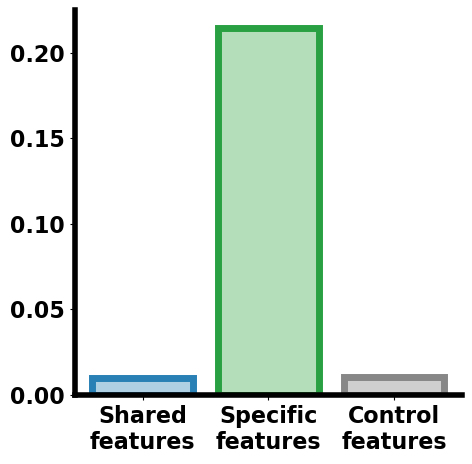

In [57]:
fig,ax = plt.subplots(figsize=(5,5))
v1 = res_cvae['rsa_zs_ens']
v2 = res_cvae['rsa_s_ens']
v3 = res_vae['rsa_s_ens']
xs = np.arange(3)

plt.bar(0,v1.mean(),color=np.array([175,207,227])/255,edgecolor=np.array([40,128,180])/255,linewidth=5)
plt.bar(1,v2.mean(),color=np.array([179,222,185])/255,edgecolor=np.array([41,161,66])/255,linewidth=5)
plt.bar(2,v3.mean(),color=np.array([207,207,207])/255,edgecolor=np.array([135,135,135])/255,linewidth=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
plt.yticks(fontsize=16,fontweight='bold');
plt.xticks([0,1,2],labels=['Shared\nfeatures','Specific\nfeatures','Control\nfeatures'],fontsize=16,fontweight='bold');

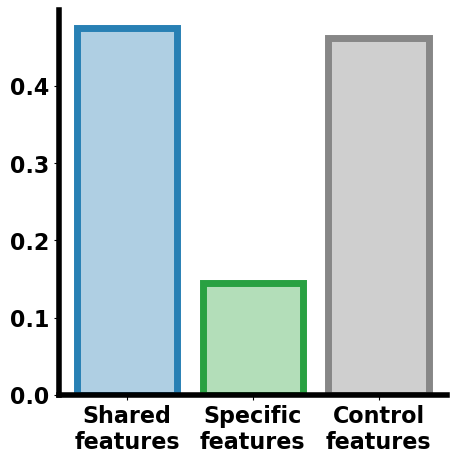

In [58]:
fig,ax = plt.subplots(figsize=(5,5))
v1 = res_cvae['rsa_z_ens']
v2 = res_cvae['rsa_sz_ens']
v3 = res_vae['rsa_z_ens']
xs = np.arange(3)

h = plt.bar(0,v1.mean(),color=np.array([175,207,227])/255,edgecolor=np.array([40,128,180])/255,linewidth=5)
plt.bar(1,v2.mean(),color=np.array([179,222,185])/255,edgecolor=np.array([41,161,66])/255,linewidth=5)
plt.bar(2,v3.mean(),color=np.array([207,207,207])/255,edgecolor=np.array([135,135,135])/255,linewidth=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
plt.yticks(fontsize=16,fontweight='bold');
plt.xticks([0,1,2],labels=['Shared\nfeatures','Specific\nfeatures','Control\nfeatures'],fontsize=16,fontweight='bold');

In [59]:
# vec_tx_s = rdm_tx_s[triu]
# vec_tx_z = rdm_tx_z[triu]

In [60]:
s_latents = res_cvae['s_latents']
z_latents = res_cvae['z_latents']
s_latents = s_latents[0,:,:,:]
z_latents = z_latents[0,:,:,:]
s_latents.shape

(20, 100, 500, 2)

In [61]:
rsa_ss = np.zeros((100,20))
rsa_sz = np.zeros((100,20))
rsa_zz = np.zeros((100,20))
rsa_zs = np.zeros((100,20))

In [62]:
triu = np.triu_indices(500,1)

In [63]:
from scipy.stats import kendalltau
for epoch in tqdm(range(100)):
    for model in range(20):
        rsa_ss[epoch,model] = kendalltau(make_RDM(s_latents[model,epoch,:,:])[triu],vec_tx_s)[0]
        rsa_sz[epoch,model] = kendalltau(make_RDM(s_latents[model,epoch,:,:])[triu],vec_tx_z)[0]
        rsa_zz[epoch,model] = kendalltau(make_RDM(z_latents[model,epoch,:,:])[triu],vec_tx_z)[0]
        rsa_zs[epoch,model] = kendalltau(make_RDM(z_latents[model,epoch,:,:])[triu],vec_tx_s)[0]

100%|█████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


In [64]:
rsa_ss.mean(axis=-1).min()

0.01623402273091092

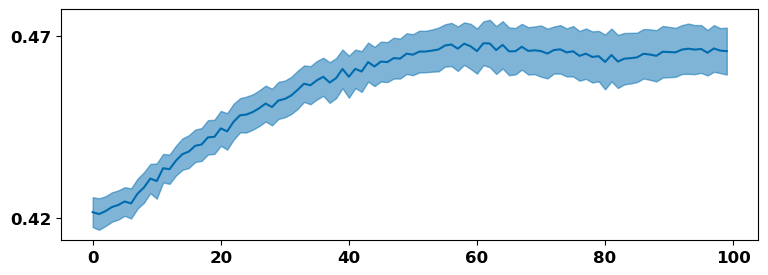

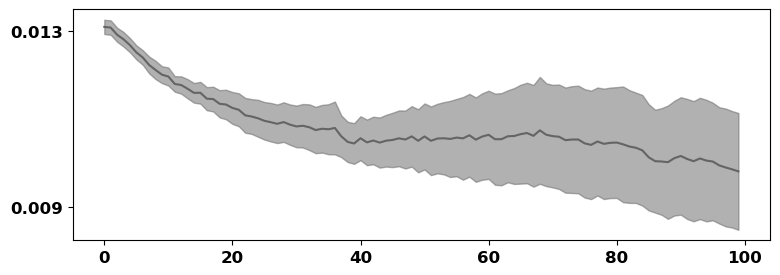

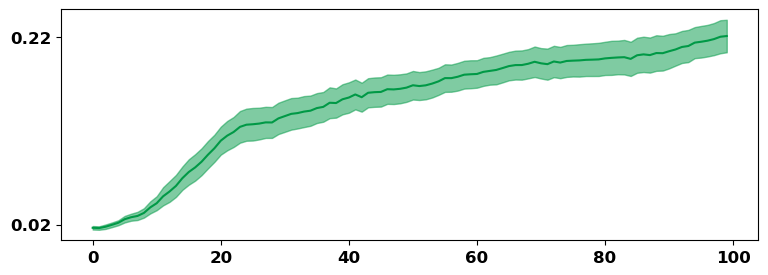

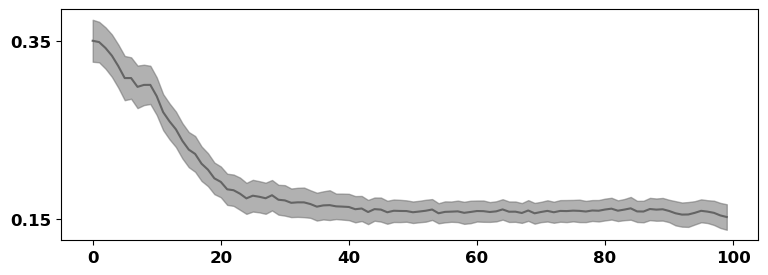

In [65]:
plt.figure(figsize=(9,3))
#plt.subplot(2,2,1)

color = np.array([0,107,174])/255
xs = np.arange(100)
ys = rsa_zz.mean(axis=-1)
se = rsa_zz.std(axis=-1) / np.sqrt(20)
plt.plot(ys,color=color)
plt.fill_between(xs,ys-se,ys+se,alpha=.5,color=color)
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks([.42,.47],fontsize=12,fontweight='bold');

plt.figure(figsize=(9,3))
#plt.subplot(2,2,2)
color = np.array([100,100,100])/255
xs = np.arange(100)
ys = rsa_zs.mean(axis=-1)
se = rsa_zs.std(axis=-1) / np.sqrt(20)
plt.plot(ys,color=color)
plt.fill_between(xs,ys-se,ys+se,alpha=.5,color=color)
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks([.009,.013],fontsize=12,fontweight='bold');

# #plt.subplot(2,2,3)
plt.figure(figsize=(9,3))
color = np.array([0,153,70])/255
xs = np.arange(100)
ys = rsa_ss.mean(axis=-1)
se = rsa_ss.std(axis=-1) / np.sqrt(20)
plt.plot(ys,color=color)
plt.fill_between(xs,ys-se,ys+se,alpha=.5,color=color)
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks([.02,.22],fontsize=12,fontweight='bold');

#plt.subplot(2,2,4)
plt.figure(figsize=(9,3))
color = np.array([100,100,100])/255
xs = np.arange(100)
ys = rsa_sz.mean(axis=-1)
se = rsa_sz.std(axis=-1) / np.sqrt(20)
plt.plot(ys,color=color)
plt.fill_between(xs,ys-se,ys+se,alpha=.5,color=color)
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks([.15,.35],fontsize=12,fontweight='bold');

In [66]:
#np.corrcoef(np.random.rand(5,10),np.random.rand(2,10))